# Deskripsi Projek
Perkembangan pesat dalam industri hiburan menghadirkan berbagai pilihan film yang sangat banyak bagi para penonton. Namun, melimpahnya pilihan tersebut seringkali menyulitkan pengguna dalam menemukan film yang sesuai dengan preferensi mereka. Sistem rekomendasi content-based filtering hadir sebagai solusi untuk membantu pengguna menemukan film-film yang relevan dengan minat mereka berdasarkan karakteristik film yang sudah mereka sukai.

Dalam proyek ini, kami membangun sistem rekomendasi film berbasis content-based filtering menggunakan dataset film dari Kaggle yang berisi judul film dan genre. Sistem ini memanfaatkan teknik ekstraksi fitur TF-IDF pada deskripsi genre film dan menghitung kemiripan antar film menggunakan cosine similarity. Dengan cara ini, sistem dapat memberikan rekomendasi film yang memiliki genre serupa dengan film yang diminati pengguna.

Dataset yang relatif kecil dipilih untuk memudahkan eksperimen dan demonstrasi konsep rekomendasi. Hasil sistem ini diharapkan dapat membantu pengguna menavigasi koleksi film secara lebih efisien dan meningkatkan pengalaman menonton mereka.

## Dataset yang digunakan
The Movies Dataset dari [kaggle](https://www.kaggle.com/rounakbanik/the-movies-dataset)
### Variabel utama
- Title : berupa judul film
- Genre : berupa tema dari film

### Import Library

Memasukkan json kaggle untuk menggunakan API kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"grandhavoc","key":"53aad8c892f982db09c5547e125582c7"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Melakukan install library kaggle

In [3]:
!pip install kaggle

In [4]:
import pandas as pd
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

# Data Understanding

Mengunduh dataset yang ada di kaggle menggunakan API dari kaggle

In [5]:
!kaggle datasets download -d neha1703/movie-genre-from-its-poster

Dataset URL: https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster
License(s): unknown
  0% 0.00/35.9M [00:00<?, ?B/s]
100% 35.9M/35.9M [00:00<00:00, 859MB/s]


Melakukan unzip data yang ada agar dapat digunakan

In [6]:
with zipfile.ZipFile("movie-genre-from-its-poster.zip", 'r') as zip_ref:
    zip_ref.extractall("movie_genre_data")

Memasukkan data yang didownload kedalam dataframe

In [23]:
df = pd.read_csv("movie_genre_data/MovieGenre.csv", encoding='ISO-8859-1')

Membuka dataframe dari dataset

In [8]:
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


### Exploratory Data Analysis

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40108 entries, 0 to 40107
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   imdbId      40108 non-null  int64  
 1   Imdb Link   40108 non-null  object 
 2   Title       40108 non-null  object 
 3   IMDB Score  40060 non-null  float64
 4   Genre       39963 non-null  object 
 5   Poster      39383 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.8+ MB


Terdapat berberapa data kosong pada variabel
- Genre
- IMDB Score
- Poster

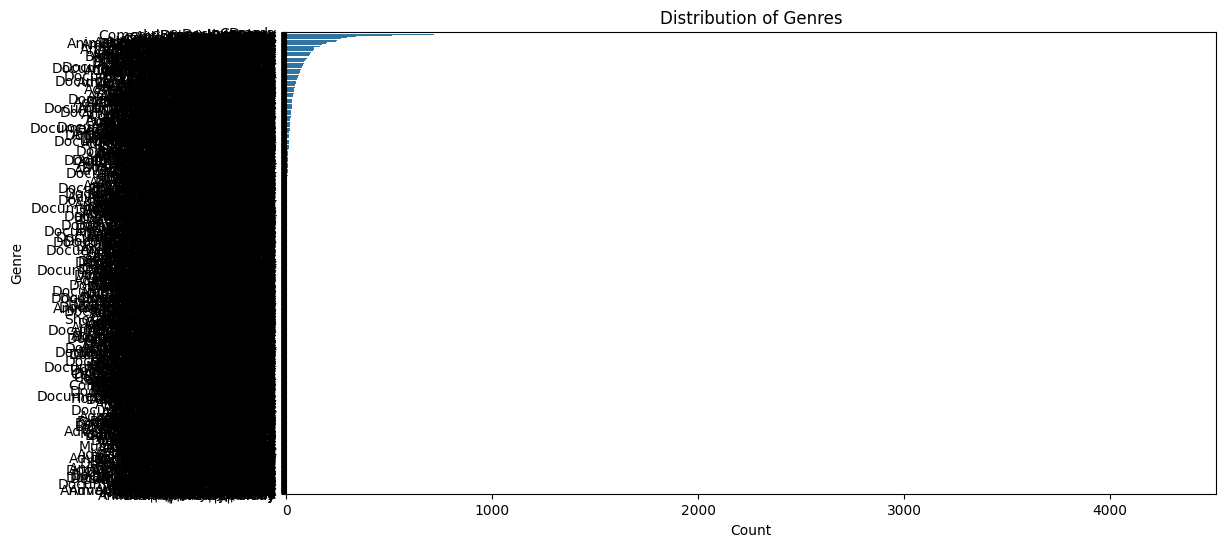

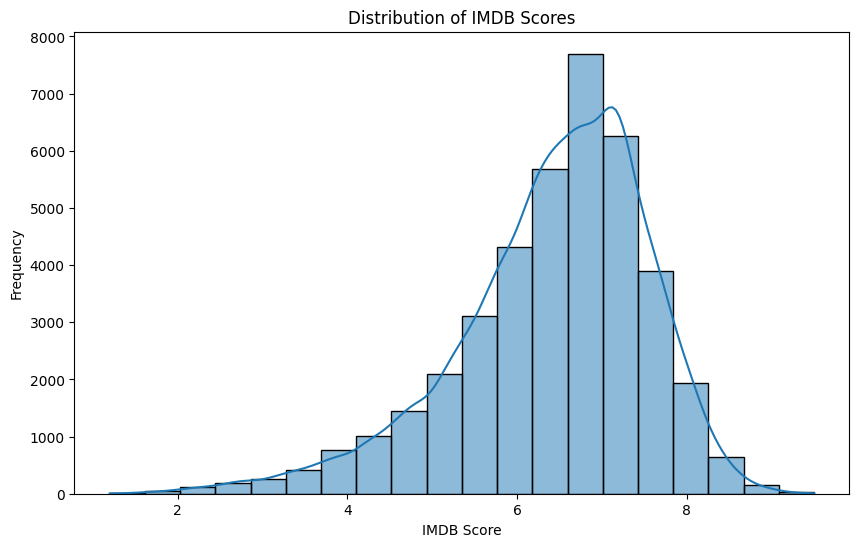

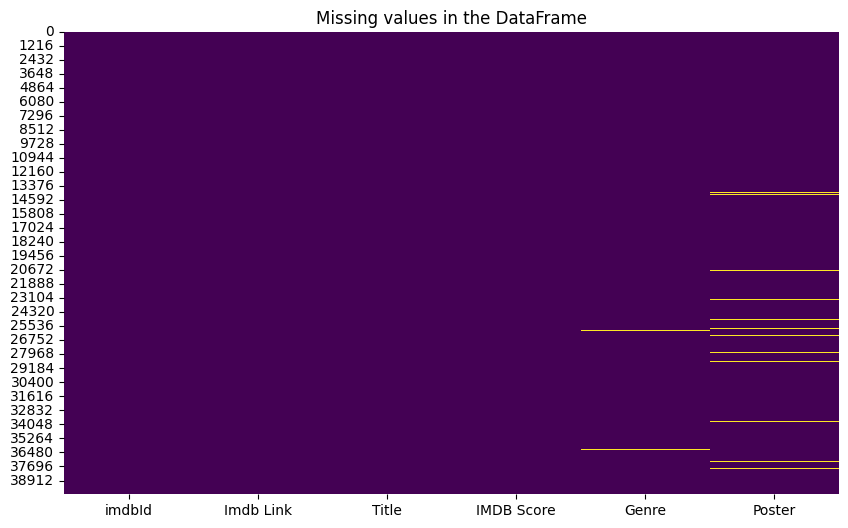

In [10]:
# Visualize the distribution of genres
plt.figure(figsize=(12, 6))
sns.countplot(y='Genre', data=df, order=df['Genre'].value_counts().index)
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

# Visualize the distribution of IMDB Scores (excluding NaNs)
plt.figure(figsize=(10, 6))
sns.histplot(df['IMDB Score'].dropna(), bins=20, kde=True)
plt.title('Distribution of IMDB Scores')
plt.xlabel('IMDB Score')
plt.ylabel('Frequency')
plt.show()

# Check for missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing values in the DataFrame')
plt.show()

Terlihat beberapa missing data pada kolom dataset Genre, Poster

# Data Preparation

### Data Cleaning

Dikarenakan menggunakan title dan genre maka kita harus menghapus data duplikasi dan data yang kosong pada kolom tersebut. Mengambil 200 data teratas dari dataset

In [11]:
df = df[['Title', 'Genre']].dropna().drop_duplicates().head(200)

Melihat 5 judul teratas

In [12]:
df.head()

,Title,Genre
0,Toy Story (1995),Animation|Adventure|Comedy
1,Jumanji (1995),Action|Adventure|Family
2,Grumpier Old Men (1995),Comedy|Romance
3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Father of the Bride Part II (1995),Comedy|Family|Romance


Membuat tfidf dengan stopword bahasa inggris dan tfidf matrix transform kolom genre

In [13]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Genre'])

Membuat cosine similarity dari matrix sebelumnya

In [14]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

fungsi membersihkan nama judul dari tahunnya

In [15]:
def clean_title(title):
    return title.lower().split(' (')[0].strip()

Dari judul yang telah dibersihkan dibuatkan kedalam indices tanpa ada duplikasi data didalamnya

In [16]:
df['clean_title'] = df['Title'].apply(clean_title)
indices = pd.Series(df.index, index=df['clean_title']).drop_duplicates()

## Modelling Content Based Filtering

Membuat fungsi rekomendasi judul

In [17]:
def recommend(title, num_recommendations=5):
    title = title.lower().strip()
    if title not in indices:
        return f"Judul '{title}' tidak ditemukan di dataset."

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations+1]
    movie_indices = [i[0] for i in sim_scores]
    return df['Title'].iloc[movie_indices]

## Evaluation

Melakukan pemanggilan judul agar mengetahui apakah ada didalamnya atau tidak

In [18]:
recommend("jumanji")

,Title
179,Mighty Morphin Power Rangers: The Movie (1995)
36,Across the Sea of Time (1995)
144,The Amazing Panda Adventure (1995)
167,Free Willy 2: The Adventure Home (1995)
55,Kids of the Round Table (1995)


Dari judul film jumanji didapatkan beberapa film dengan kesamaan genre film yaitu
- Mighty Morphin Power Rangers: The Movie
- Across the Sea of Time
- The Amazing Panda Adventure
- Free Willy 2: The Adventure Home
- Kids of the Round Table

In [19]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(tfidf_matrix)

score = silhouette_score(tfidf_matrix, labels)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.234


Dengan menggunakan model cosine similarity ini dan evaluasi menggunakan silhouette score didapatkan berupa 0.234 hasil evaluasinya yang menggambarkan cluster yang kurang kuat namun masih bisa digunakan sebagai baseline pada proyek ini. Terdapat tumpang tindih atau kemiripan antar cluster ini dengan cluster lain yang cukup tinggi.

Membuat fungsi menghitung recall dan precision

In [26]:
def calculate_precision_recall(df, title_input, top_n=5):
    # Membersihkan judul
    title_input = title_input.lower().strip()

    # Cek apakah judul ada di dataset
    if title_input not in indices:
        print(f"Judul '{title_input}' tidak ditemukan dalam dataset.")
        return

    # Ambil genre film input
    input_index = indices[title_input]
    input_genres = set(df.loc[input_index, 'Genre'].lower().split('|'))

    # Ambil rekomendasi film
    recommended_titles = recommend(title_input, num_recommendations=top_n)

    if isinstance(recommended_titles, str):
        print(recommended_titles)
        return

    true_positive = 0
    total_recommended = 0
    total_relevant = len(input_genres)
    found_genres = set()

    print(f"\nFilm input: {df.loc[input_index, 'Title']}")
    print(f"Genre input: {input_genres}\n")
    print("Film rekomendasi dan genre-nya:")

    for title in recommended_titles:
        genre = df[df['Title'] == title]['Genre'].values[0].lower().split('|')
        genre_set = set(genre)
        print(f"- {title} => {genre_set}")

        intersection = input_genres.intersection(genre_set)
        true_positive += len(intersection)
        found_genres.update(intersection)
        total_recommended += len(genre_set)

    precision = true_positive / total_recommended if total_recommended > 0 else 0
    recall = len(found_genres) / total_relevant if total_relevant > 0 else 0

    print(f"\nPrecision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

memanggil inputan berupa jumanji dan top 5 rekomendasinya

In [27]:
calculate_precision_recall(df, title_input='jumanji', top_n=5)


Film input: Jumanji (1995)
Genre input: {'action', 'adventure', 'family'}

Film rekomendasi dan genre-nya:
- Mighty Morphin Power Rangers: The Movie (1995) => {'action', 'adventure', 'family'}
- Across the Sea of Time (1995) => {'adventure', 'family', 'drama'}
- The Amazing Panda Adventure (1995) => {'adventure', 'family', 'drama'}
- Free Willy 2: The Adventure Home (1995) => {'adventure', 'family', 'drama'}
- Kids of the Round Table (1995) => {'family', 'adventure', 'comedy'}

Precision: 0.73
Recall: 1.00


Dari sini didapatkan precision berupa 0.73 dan recall berupa 1.00 pada film berjudul Jumanji dengan genre action, adventure, family. Didapatkan film rekomendasi dan genre:
- Mighty Morphin Power Rangers: The Movie (1995) dengan genre action, adventure, family.
- Across the Sea of Time (1995) dengan genre adventure, family, drama.
- The Amazing Panda Adventure (1995) dengan genre adventure, famly, drama.
- Free Willy 2: The Adventure Home (1995) dengan genre adventure, family, drama.
- Kids of the Round Table (1995) dengan genre family, adventure, comedy.